In [1]:
# In[] # import libraries 
from scipy.signal import savgol_filter
from utils_process import get_crossing, phase_shift, noise_estimation_fixed, spike_detection_ori5_fast
from utils_process import peaks_on_flatten, choose_chunk_peak, calculate_50hz_fourier_coefficient, process_measurement, create_global_features
import time 
import pickle
import pyarrow 
import pyarrow.parquet as pq
import pandas as pd
from train import whole_process_training_single_iter, whole_process_training, whole_Network_training
from utils_model import display_metrics

import random
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt 


# STEP 0 Data Visualization 

In [2]:
# =============================================================================
# #################### STEP 0 Data Visualization ##############################
# =============================================================================
data_dir = 'vsb-power-line-fault-detection/'
# signal_df = pq.read_pandas(data_dir + 'train.parquet', columns=[str(i) for i in range(3,6)]).to_pandas()
signal_df_0 = pq.read_pandas(data_dir + 'train.parquet', columns=[str(i) for i in range(3)]).to_pandas()
signal_df_1 = pq.read_pandas(data_dir + 'train.parquet', columns=[str(i) for i in range(3,6)]).to_pandas()
signal_len = signal_df_1.shape[0]
signal_df_0

,0,1,2
0,18,1,-19
1,18,0,-19
2,17,-1,-20
3,18,1,-19
4,18,0,-19
...,...,...,...
799995,19,2,-18
799996,19,1,-19
799997,17,0,-19
799998,19,1,-18


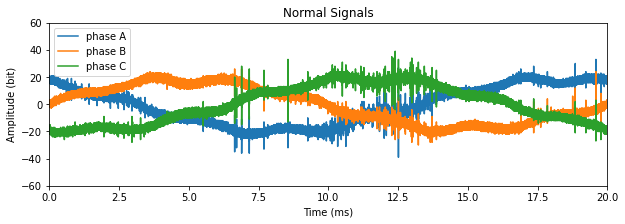

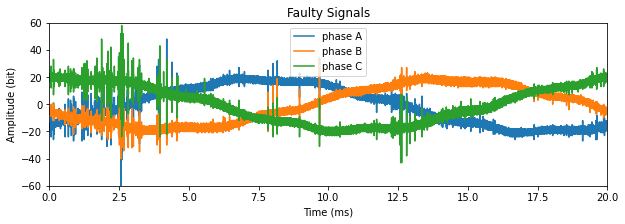

In [3]:
### Figure 1
x_time = np.linspace(0,20,signal_len)
plt.figure(figsize=(10,3))
plt.plot(x_time, signal_df_0)
plt.legend(['phase A', 'phase B', 'phase C'])
plt.xlim([0, 20])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (bit)')
plt.ylim([-60,60])
plt.title('Normal Signals')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(x_time, signal_df_1)
plt.legend(['phase A', 'phase B', 'phase C'])
plt.xlim([0, 20])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (bit)')
plt.ylim([-60,60])
plt.title('Faulty Signals')
plt.show()

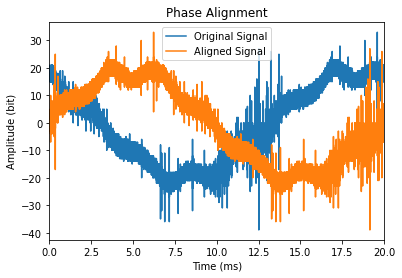

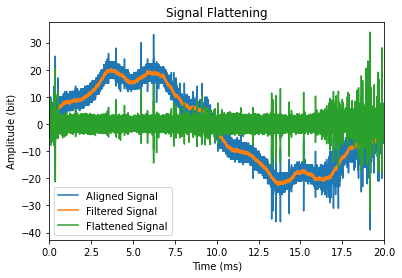

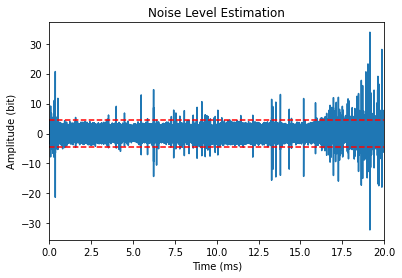

In [4]:
### Figure 2(b) Signal Pre-Processing
index = 0
signal = signal_df_0[str(index)].values
crossing = get_crossing(signal)
signal = phase_shift(signal, crossing)
yhat = savgol_filter(signal, 99, 3)
flat = signal - yhat
noise_level = noise_estimation_fixed(flat)
points = spike_detection_ori5_fast(flat, noise_level=noise_level)
points = np.array(points)

plt.plot(x_time, signal_df_0[str(index)])
plt.plot(x_time, signal)
plt.xlim([0,800000])
plt.title('Phase Alignment')
plt.xlim([0, 20])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (bit)')
plt.legend(['Original Signal', 'Aligned Signal'])
plt.show()

# plt.plot(signal_df_1[str(index)])
plt.plot(x_time, signal)
plt.plot(x_time, yhat)
plt.plot(x_time, flat)
plt.xlim([0, 20])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (bit)')
plt.title('Signal Flattening')
plt.legend(['Aligned Signal', 'Filtered Signal', 'Flattened Signal'])
plt.show()

plt.plot(x_time,flat)
plt.axhline(noise_level, color='r', linestyle='--')
plt.axhline(-noise_level, color='r', linestyle='--')
# plt.scatter(points[:,0], points[:,1], color='r')
plt.xlim([0, 20])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (bit)')
plt.title('Noise Level Estimation')
plt.show()

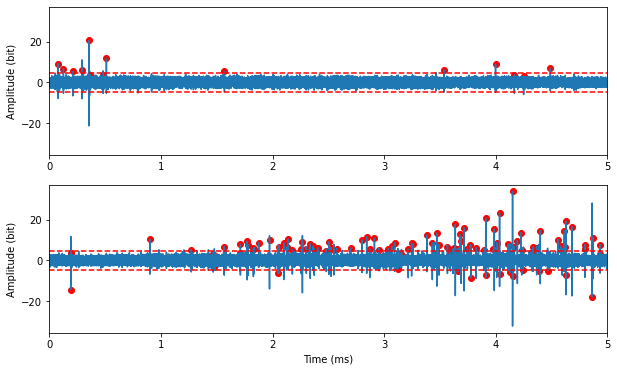

In [5]:
### Figure 2(c) Pulse Detection
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(x_time, flat)
ax[0].axhline(noise_level, color='r', linestyle='--')
ax[0].axhline(-noise_level, color='r', linestyle='--')
ax[0].scatter(points[:,0]/800000*20, points[:,1], color='r')
ax[0].set_xlim([0,5])
# ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Amplitude (bit)')
# ax[0].set_title('Pulse Detection on Flattened Signal')

ax[1].plot(x_time-15, flat)
ax[1].axhline(noise_level, color='r', linestyle='--')
ax[1].axhline(-noise_level, color='r', linestyle='--')
ax[1].scatter(points[:,0]/800000*20-15, points[:,1], color='r')
ax[1].set_xlim([0,5])
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Amplitude (bit)')
# ax[1].set_title('Pulse Detection on Flattened Signal')
plt.show()

# STEP 1 Preprocessing & Feature Extraction 

In [6]:
# In[] # settings 
preprocessed = True
recalculate_peaks = False 
input_dir = 'processed_input/'
# signal_len = 800000
# window_sizes = [2000, 4000, 5000, 8000] 
window_size = 4000
nchunks = int(signal_len / window_size)

In [7]:
# In[] metadata
meta_df = pd.read_csv('metadata_train.csv')
signal_ids = meta_df['signal_id'].values

In [8]:
# =============================================================================
# ############ STEP 1 Preprocessing & Feature Extraction ######################
# =============================================================================
if not preprocessed:
    signal_df = pq.read_pandas(input_dir + 'train.parquet').to_pandas()
    _, all_flat_signals, all_points = peaks_on_flatten(signal_df, signal_ids)

    ##### STEP 1A. Denoise & Extract Waveforms #####
    # construct waveforms with given window size 
    waveforms = choose_chunk_peak(all_flat_signals, all_points, window_size=window_size)
    print(waveforms.shape)
    pickle.dump(waveforms, open(input_dir + 'all_chunk_waves_{}chunks.dat'.format(nchunks), 'wb'))

    ##### STEP 1B. Extract Global Features #####
    if recalculate_peaks:
        signal_fft = calculate_50hz_fourier_coefficient(signal_df.values)
        signal_peaks = process_measurement(signal_df, meta_df, signal_fft)
        signal_peaks.to_pickle('signal_peaks.pkl')
        del signal_fft
        gc.collect()
    else:
        signal_peaks = pd.read_pickle(input_dir + 'signal_peaks.pkl')
    signal_peaks = pd.merge(signal_peaks, meta_df[['signal_id', 'id_measurement', 'target']], on='signal_id', how='left')

    ### load KMeans results
    # x, x_A, x_B, x_C = pickle.load(open('waves_list.dat','rb'))
    # kmeans = KMeans(n_clusters=15, random_state=9, init='k-means++').fit(x)
    # kmeans_A = KMeans(n_clusters=6, random_state=9, init='k-means++').fit(x_A)
    # kmeans_B = KMeans(n_clusters=6, random_state=9, init='k-means++').fit(x_B)
    # kmeans_C = KMeans(n_clusters=6, random_state=9, init='k-means++').fit(x_C)
    kmeans = pickle.load(open(input_dir + 'kmeans.dat', 'rb'))
    kmeans_A = pickle.load(open(input_dir + 'kmeans_A.dat', 'rb'))
    kmeans_B = pickle.load(open(input_dir + 'kmeans_B.dat', 'rb'))
    kmeans_C = pickle.load(open(input_dir + 'kmeans_C.dat', 'rb'))

    X_global = create_global_features(meta_df, signal_peaks, kmeans, kmeans_A, kmeans_B, kmeans_C)
    X_global.to_csv(input_dir + 'global_features.csv')

else:
    X_global = pd.read_csv(input_dir + 'global_features.csv')
    waveforms = pickle.load(open(input_dir + 'all_chunk_waves_{}chunks.dat'.format(nchunks), 'rb'))

X_global.set_index('id_measurement', inplace=True)

# STEP 2 Model Training

In [9]:
# =============================================================================
# ###################### STEP 2 Model Training ################################
# =============================================================================
import random
import numpy as np
import tensorflow as tf
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# In[] parameters
loss_name = 'weighted_bce'
output_folder = 'results_{}chunks_{}'.format(nchunks, loss_name)
# local_features = True 
load_local_features = True 
NN_level = 'signal'
NN_model = 'LSTM'
Dense_layers = 2
NN_pretrained = True 
layer_idx = 5 
NN_batch_size = 512 
classifier = 'XGboost'
classifier_level = 'measurement'
num_folds = 5 
num_iterations = 25 
feature_set = 'global'
kfold_random_state = 123948
pretrained = True 
predict = True 
weights_dict = None 
monitor = 'val_loss'
dropout = 0.4 
regularizer = 'l2'
from_logits = True
n_epochs = 100

## LMFE

In [10]:
########### LMFE ########### 
_, best_proba_LMFE, metrics_LMFE, test_pred_LMFE = whole_process_training(meta_df, waveforms, X_global,
    local_features=True, NN_level=NN_level, NN_model=NN_model,
    Dense_layers=Dense_layers, NN_pretrained=NN_pretrained, layer_idx=layer_idx, NN_batch_size=NN_batch_size, 
    output_folder=output_folder, classifier=classifier, classifier_level=classifier_level, num_folds=num_folds,
    num_iterations=num_iterations, feature_set=feature_set, kfold_random_state=kfold_random_state, 
    load_local_features=load_local_features, pretrained=pretrained, predict=predict, early_stopping_rounds=100, 
    verbose_eval=0, weights_dict=weights_dict, monitor=monitor, dropout=dropout, regularizer=regularizer, 
    loss_name=loss_name, from_logits=from_logits, n_epochs=n_epochs)
# test_pred_LMFE.to_csv(output_folder + '/test_pred_LMFE.csv')
metrics_LMFE = display_metrics(test_pred_LMFE)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.01it/s]


Best Probability Threshold based on validation set: 0.404
MCC Training: 0.946
MCC Validation: 0.727
MCC Test: 0.730
For best probability thresholded: 0.404,
         mcc:0.7302598775889093, precision:0.7115716753022453, recall:0.7847619047619048, f1:0.746376811594203, acc:0.967860422405877, roc_auc:0.8821818562529445,average_precision:0.5713849585281522



C:\Users\Chao Huang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## Only global-scale features

In [11]:
########### Only global-scale features ########### 
###### all global-scale features
# _, best_proba_global, metrics_global, test_pred_global = whole_process_training(meta_df, waveforms, X_global,
#     local_features=False, NN_level=NN_level, NN_model=NN_model, 
#     Dense_layers=Dense_layers, NN_pretrained=NN_pretrained, layer_idx=layer_idx, NN_batch_size=NN_batch_size, 
#     output_folder=output_folder, classifier='LightGBM', classifier_level=classifier_level, num_folds=num_folds,
#     num_iterations=num_iterations, feature_set='global', kfold_random_state=kfold_random_state, 
#     load_local_features=load_local_features, pretrained=pretrained, predict=predict, early_stopping_rounds=100, 
#     verbose_eval=0, weights_dict=weights_dict, monitor=monitor, dropout=dropout, regularizer=regularizer, 
#     loss_name=loss_name, from_logits=from_logits, n_epochs=n_epochs)
# test_pred_global.to_csv(output_folder + '/test_pred_global.csv')
test_pred_global = pd.read_csv(output_folder + '/test_pred_global.csv')
metrics_global = display_metrics(test_pred_global)

###### only phase-level features
# _, best_proba_phase, metrics_phase, test_pred_phase = whole_process_training(meta_df, waveforms, X_global,
#     local_features=False, NN_level=NN_level, NN_model=NN_model, 
#     Dense_layers=Dense_layers, NN_pretrained=NN_pretrained, layer_idx=layer_idx, NN_batch_size=NN_batch_size, 
#     output_folder=output_folder, classifier='LightGBM', classifier_level=classifier_level, num_folds=num_folds,
#     num_iterations=num_iterations, feature_set='phase_level', kfold_random_state=kfold_random_state, 
#     load_local_features=load_local_features, pretrained=pretrained, predict=predict, early_stopping_rounds=100, 
#     verbose_eval=0, weights_dict=weights_dict, monitor=monitor, dropout=dropout, regularizer=regularizer, 
#     loss_name=loss_name, from_logits=from_logits, n_epochs=n_epochs)
# test_pred_phase.to_csv(output_folder + '/test_pred_phase.csv')
test_pred_phase = pd.read_csv(output_folder + '/test_pred_phase.csv')
metrics_phase = display_metrics(test_pred_phase)

###### only measurement-level features
# _, best_proba_measure, metrics_measure, test_pred_measure = whole_process_training(meta_df, waveforms, X_global,
#     local_features=False, NN_level=NN_level, NN_model=NN_model, 
#     Dense_layers=Dense_layers, NN_pretrained=NN_pretrained, layer_idx=layer_idx, NN_batch_size=NN_batch_size, 
#     output_folder=output_folder, classifier='LightGBM', classifier_level=classifier_level, num_folds=num_folds,
#     num_iterations=num_iterations, feature_set='measurement_level', kfold_random_state=kfold_random_state, 
#     load_local_features=load_local_features, pretrained=pretrained, predict=predict, early_stopping_rounds=100, 
#     verbose_eval=0, weights_dict=weights_dict, monitor=monitor, dropout=dropout, regularizer=regularizer, 
#     loss_name=loss_name, from_logits=from_logits, n_epochs=n_epochs)
# test_pred_measure.to_csv(output_folder + '/test_pred_measure.csv')
test_pred_measure = pd.read_csv(output_folder + '/test_pred_measure.csv')
metrics_measure = display_metrics(test_pred_measure)

## Only local-scale features

In [12]:
########### Only local-scale features ########### 
#### Prediction on test set
# _, best_proba_RNN, metrics_RNN, test_pred_RNN, _ = whole_Network_training(meta_df, waveforms,
#     NN_level=NN_level, NN_model=NN_model, Dense_layers=Dense_layers, NN_pretrained=NN_pretrained, 
#     layer_idx=layer_idx, NN_batch_size=NN_batch_size, indice_level=classifier_level,
#     output_folder=output_folder, kfold_random_state=kfold_random_state, num_folds=num_folds,
#     num_iterations=num_iterations, predict=predict, monitor=monitor, dropout=dropout, regularizer=regularizer,
#     from_logits=from_logits, loss_name=loss_name, extract_attention_weights=False)
# test_pred_RNN.to_csv(output_folder + '/test_pred_RNN.csv')
# load test set prediction
test_pred_RNN = pd.read_csv(output_folder + '/test_pred_RNN.csv')
metrics_RNN = display_metrics(test_pred_RNN)

## Table II Performance 

In [13]:
# In[] display the performance
all_metrics = np.array([metrics_LMFE, metrics_global, metrics_phase, metrics_measure, metrics_RNN])
df_res = pd.DataFrame(data=all_metrics, index=['LMFE', 'Global-scale', 'Phase', 'Measurement', 'RNN'], 
    columns=['MCC', 'Precision', 'Recall', 'F1 Score', 'AUC'])
print(df_res)

                   MCC  Precision    Recall  F1 Score       AUC
LMFE          0.730260   0.711572  0.784762  0.746377  0.882182
Global-scale  0.705548   0.735700  0.710476  0.722868  0.847054
Phase         0.708669   0.712454  0.740952  0.726424  0.860888
Measurement   0.706481   0.796296  0.655238  0.718913  0.822245
RNN           0.679368   0.632970  0.775238  0.696918  0.873206


# STEP 3 Model Evaluation

In [14]:
# =============================================================================
# ###################### STEP 3 Model Evaluation ##############################
# =============================================================================
load_attention_weights = True

# In[] extract attention weights
if not load_attention_weights:
    _, _, _, _, attention_weights = whole_Network_training(meta_df, waveforms,
            NN_level=NN_level, NN_model=NN_model, Dense_layers=Dense_layers, NN_pretrained=NN_pretrained, 
            layer_idx=layer_idx, NN_batch_size=NN_batch_size, indice_level=classifier_level,
            output_folder=output_folder, kfold_random_state=kfold_random_state, num_folds=num_folds,
            num_iterations=num_iterations, predict=False, monitor=monitor, dropout=dropout, regularizer=regularizer,
            kernel_size=kernel_size, from_logits=from_logits, loss_name=loss_name, extract_attention_weights=True)

    pickle.dump(attention_weights.squeeze(), open(output_folder + '/attention_weights_{}_{}Dense_layers_{}_level.dat'.format(NN_model, 
        Dense_layers, NN_level), 'wb'))
else:
    attention_weights = pickle.load(open(output_folder + '/attention_weights_{}_{}Dense_layers_{}_level.dat'.format(NN_model, 
        Dense_layers, NN_level), 'rb'))

## Obtain representative waveforms with largest weights for each signal

In [15]:
### Obtain representative waveforms with largest weights for each signal
max_weights_loc = np.argmax(attention_weights.squeeze(), 1) # length N
weighted_waves = np.zeros((waveforms.shape[0], waveforms.shape[2]))
for i in range(len(max_weights_loc)):
    weighted_waves[i, :] = waveforms[i, max_weights_loc[i], :]
normalized_weighted_waves = weighted_waves * np.sign(weighted_waves[:, 15]).reshape(-1,1) / np.max(abs(weighted_waves), axis=1).reshape(-1,1)


<ipython-input-15-e44ff0cdaeda>:6: RuntimeWarning: invalid value encountered in true_divide
  normalized_weighted_waves = weighted_waves * np.sign(weighted_waves[:, 15]).reshape(-1,1) / np.max(abs(weighted_waves), axis=1).reshape(-1,1)


### Clustering for all faulty signals

In [16]:
### Clustering for all faulty signals
y_data = meta_df['target'].values
normalized_faulty_waves = normalized_weighted_waves[y_data==1, :] # (525,30)
NA = np.isnan(normalized_faulty_waves)[:, 0]
new_faulty = normalized_faulty_waves[~NA, :]

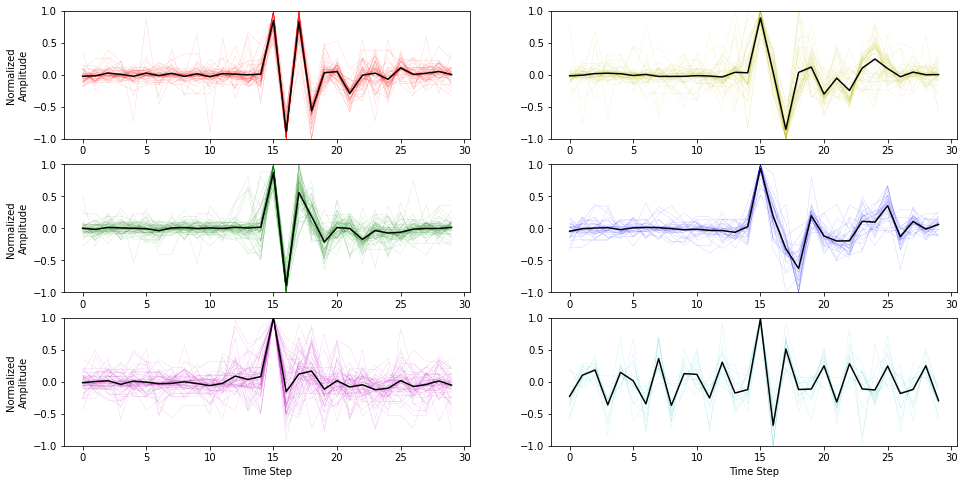

In [17]:
# # choose number of clusters
# Sum_of_squared_distances = []
# K = range(1,10)
# for num_clusters in K :
#     kmeans = KMeans(n_clusters=num_clusters,random_state=9, init='k-means++')
#     kmeans.fit(new_faulty)
#     Sum_of_squared_distances.append(kmeans.inertia_)
# plt.plot(K,Sum_of_squared_distances,color='b')
# plt.xlabel('Values of K') 
# plt.ylabel('Sum of squared distances/Inertia') 
# plt.title('Elbow Method For Optimal k')
# plt.show()


kmeans_faulty = KMeans(n_clusters=6, random_state=9, init='k-means++').fit(new_faulty)
### visualization
y_faulty = kmeans_faulty.predict(new_faulty)
centroid_faulty = kmeans_faulty.cluster_centers_
colors = ['r','y','g','b','m','c']
fig, ax = plt.subplots(3,2,figsize=(16,8))
for i in range(6):
    xx = new_faulty[y_faulty == i, ]
    ax[i//2,i%2].plot(xx[:100,].T, color=colors[i], linestyle=':',linewidth=0.2)
    ax[i//2,i%2].plot(centroid_faulty[i,], color='k')
    ax[i//2,i%2].set_ylim(-1,1)
    ax[2,i%2].set_xlabel('Time Step')
    ax[i//2, 0].set_ylabel('Normalized \nAmplitude')
plt.show()